# ISIC 2024 Challenge: Skin Cancer Detection

## Team Contributions

### Preprocessing and Exploratory Data Analysis (EDA)
- **Contributor:** Debankita Basu
- **Responsibilities:** Data cleaning, handling missing values, encoding categorical variables, normalizing continuous variables, and performing exploratory data analysis including visualizations.

### Feature Engineering
- **Contributor:** Rashi Tiwary
- **Responsibilities:** Creating interaction features, addressing class imbalance, dimensionality reduction, feature selection, and transformation.

---



# 1. Installations and Set-up



In [1]:
# Installing required libraries
!pip install kaggle
!pip install seaborn
!pip install scikit-learn

Setting up Kaggle API

To access Kaggle datasets directly from Colab,  set up the Kaggle API.

Go to Kaggle account, navigate to Account, and scroll down to the API section.
Click Create New API Token. This will download a kaggle.json file containing  API credentials.
Now, upload this kaggle.json file to  Colab environment:

In [2]:
from google.colab import files
files.upload()  # upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rashitiwary","key":"9625b606afa95f17b0dcda66a1012154"}'}

In [3]:
# Configure Kaggle API
# Once the kaggle.json file is uploaded, move it to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Download the ISIC 2024 Dataset using Kaggle API
!kaggle competitions download -c isic-2024-challenge
!unzip isic-2024-challenge.zip -d isic2024/


Streaming output truncated to the last 5000 lines.
  inflating: isic2024/train-image/image/ISIC_9874656.jpg  
  inflating: isic2024/train-image/image/ISIC_9874659.jpg  
  inflating: isic2024/train-image/image/ISIC_9874663.jpg  
  inflating: isic2024/train-image/image/ISIC_9874742.jpg  
  inflating: isic2024/train-image/image/ISIC_9874751.jpg  
  inflating: isic2024/train-image/image/ISIC_9874803.jpg  
  inflating: isic2024/train-image/image/ISIC_9874805.jpg  
  inflating: isic2024/train-image/image/ISIC_9874832.jpg  
  inflating: isic2024/train-image/image/ISIC_9874878.jpg  
  inflating: isic2024/train-image/image/ISIC_9874897.jpg  
  inflating: isic2024/train-image/image/ISIC_9874925.jpg  
  inflating: isic2024/train-image/image/ISIC_9874931.jpg  
  inflating: isic2024/train-image/image/ISIC_9874939.jpg  
  inflating: isic2024/train-image/image/ISIC_9874940.jpg  
  inflating: isic2024/train-image/image/ISIC_9874963.jpg  
  inflating: isic2024/train-image/image/ISIC_9874987.jpg  
  inf

# 2. Load and Explore Data

In [5]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures


In [6]:
# Load the training metadata into a Pandas DataFrame to begin EDA
train_metadata = pd.read_csv('isic2024/train-metadata.csv')
train_metadata.head()


<ipython-input-6-c47846c9932a>:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv('isic2024/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


### **Initial Observations:**
Missing Data: Several fields contain missing values (NaN). This might require data imputation strategies or careful consideration during feature selection.

Class Imbalance: Given that the example rows are all benign, need to find whether there is class imbalance in the full dataset. This is common in medical datasets and might require special handling, such as resampling or using weighted loss functions.

Metadata Richness: The dataset is rich in metadata, with 55 columns that can provide valuable insights into each case. Proper feature engineering and selection will be crucial to leveraging this information effectively.

Data Consistency: In next steps ensuring that all data types are consistent (e.g., numerical fields should be numeric, categorical fields should be correctly encoded) is necessary.

In [7]:
# Display the column names in the train_metadata DataFrame
print(train_metadata.columns)


Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [8]:
# Check missing values
train_metadata.isnull().sum()


,0
isic_id,0
target,0
patient_id,0
age_approx,2798
sex,11517
anatom_site_general,5756
clin_size_long_diam_mm,0
image_type,0
tbp_tile_type,0
tbp_lv_A,0


###**Observations on Missing Values:**

age_approx: Approximately 2,798 entries are missing for the patient's approximate age. This is a critical feature, and missing values may need to be imputed or handled carefully.

sex: A significant number of entries (11,517) are missing for the patient's sex. This could be important for the analysis, as sex can influence skin cancer risk.

anatom_site_general: 5,756 entries lack information on the general location of the lesion on the body. This feature might be important for determining lesion risk based on body location.

lesion_id: A very large portion of entries (379,001) are missing the lesion identifier. This column seems to be sparsely populated and might not be useful unless specifically analyzing subsets of the data.

iddx_2 to iddx_5 (Lesion Diagnosis Levels): There is a high rate of missing data in these columns, especially for iddx_3 through iddx_5, with nearly 400,000 entries missing. These columns might be highly specific or applicable only to certain cases.

mel_mitotic_index and mel_thick_mm: Over 400,000 entries are missing in these melanoma-specific features, indicating they are only relevant for a subset of cases.

Other Columns: All other features, particularly those related to the TBP image analysis (e.g., tbp_lv_ series), have complete data with no missing values.

### **Summary:**
The dataset contains a significant amount of missing data in key demographic and diagnostic features (age_approx, sex, anatom_site_general).

The high rate of missing data in specific diagnostic fields (e.g., lesion_id, iddx_2 to iddx_5) and melanoma-specific features (mel_mitotic_index, mel_thick_mm) suggests that these columns are either highly specialized or irrelevant to most cases.



In [9]:
# Summary statistics
train_metadata.describe()


,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,...,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,...,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,...,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,...,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,...,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,...,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,...,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,...,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


### **Summary Statistics Observations:**
**Target Variable (target):**

Mean: The mean is approximately 0.00098, indicating that the dataset is heavily skewed toward benign cases (almost all cases are benign, with very few malignant).

Std (Standard Deviation): The very low standard deviation (0.031) confirms this skewness.
Min/Max: The binary nature of the target variable is reflected, with a minimum of 0 (benign) and a maximum of 1 (malignant).

**Age Approximation (age_approx):**

Mean: The average age is around 58 years, with a standard deviation of approximately 13.6 years.

Range: Ages range from 5 to 85 years, with the middle 50% of patients (IQR) aged between 50 and 70 years. This suggests the dataset primarily involves older adults, who are generally at higher risk for skin cancer.

**Clinical Size of Lesion (clin_size_long_diam_mm):**

Mean: The average lesion size is about 3.93 mm, with a standard deviation of 1.74 mm.

Range: The lesion sizes vary widely, from 1 mm to a maximum of 28.4 mm, with the majority of lesions between 2.84 mm and 4.38 mm. Larger lesions might indicate a higher risk, but the majority are relatively small.

**Lesion Characteristics (tbp_lv_* columns):**

These columns represent various lesion characteristics related to color, contrast, and symmetry, derived from image analysis:

Mean Values: These values vary widely, with some features like tbp_lv_A and tbp_lv_B averaging around 20-28, while others like tbp_lv_H (hue) have a mean of 54.65.

Range: The values range significantly, indicating that these features capture a broad spectrum of lesion characteristics, which could be crucial for distinguishing between benign and malignant lesions.

**Melanoma Thickness (mel_thick_mm):**

Mean: For the subset of data where this is available, the average melanoma thickness is around 0.67 mm, with a maximum thickness of 5.0 mm. This feature is important for assessing the severity of melanomas.

**AI Model Confidence (tbp_lv_dnn_lesion_confidence):**

Mean: The AI model’s confidence in identifying lesions is high, with an average confidence score of 97.16 out of 100.

Range: Confidence ranges from almost zero to 100, showing that the model is highly confident in most of its assessments, but there are cases where it is uncertain.

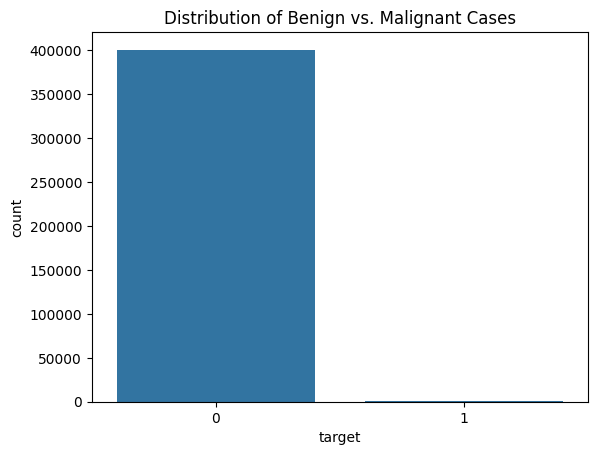

In [10]:
# Visualize class distribution of the target variable (benign vs. malignant)
sns.countplot(x='target', data=train_metadata)
plt.title('Distribution of Benign vs. Malignant Cases')
plt.show()


The class distribution visualization shows a severe imbalance, with almost all cases being benign (target = 0) and very few malignant (target = 1). This imbalance poses a risk of bias in model predictions toward the benign class. To address this, considering resampling techniques, using weighted loss functions, and focusing on metrics like ROC-AUC, precision, recall, and F1-score, particularly for the malignant class is necessary. Handling this imbalance is crucial for developing an effective model.

# 3. Image Data Visualization

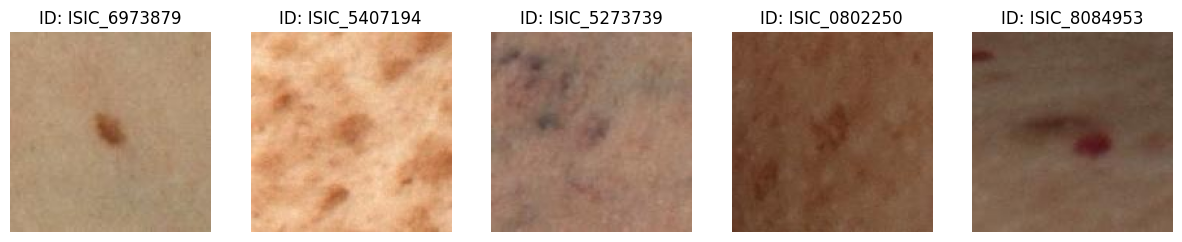

In [11]:
# Visualize a few sample images from the dataset along with their labels
image_dir = 'isic2024/train-image/image/'

def show_images(image_ids, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, image_id in enumerate(image_ids[:num_images]):
        image_path = os.path.join(image_dir, image_id + '.jpg')
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"ID: {image_id}")
    plt.show()

sample_ids = train_metadata['isic_id'].sample(5, random_state=42).values
show_images(sample_ids)


### **Key Observations:**

**Visual Diversity:**

The images show a variety of lesion appearances, with differences in size, color, texture, and surrounding skin tone. This diversity highlights the challenge of skin cancer detection, as lesions can vary widely in their presentation.

**Image Quality:**

The images are of good resolution and focus, which is important for accurate feature extraction during model training.

**Potential Features:**

Visual characteristics like lesion color, border irregularity, and contrast with surrounding skin could be crucial features for distinguishing between benign and malignant cases.

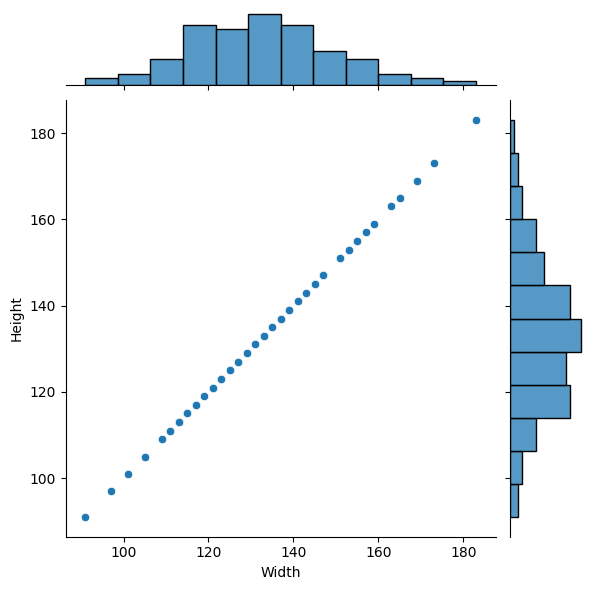

In [12]:
# Check image dimensions to ensure consistency across the dataset
image_sizes = []
for image_id in train_metadata['isic_id'].sample(100):
    image_path = os.path.join(image_dir, image_id + '.jpg')
    with Image.open(image_path) as img:
        image_sizes.append(img.size)
image_sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
sns.jointplot(x='Width', y='Height', data=image_sizes_df, kind='scatter')
plt.show()


### **Image Dimensions Consistency:**
**Observation:** The scatter plot of image dimensions (Width vs. Height) shows a strong linear relationship, indicating that images are mostly consistent in their aspect ratio. However, there is some variation in both width and height, suggesting that not all images are of the same size.

**Next Steps:** To ensure consistency during model training, you should resize all images to a common dimension as part of the preprocessing pipeline. This will standardize the input data and improve model performance.

# 4. Exploratory Data Analysis (EDA)

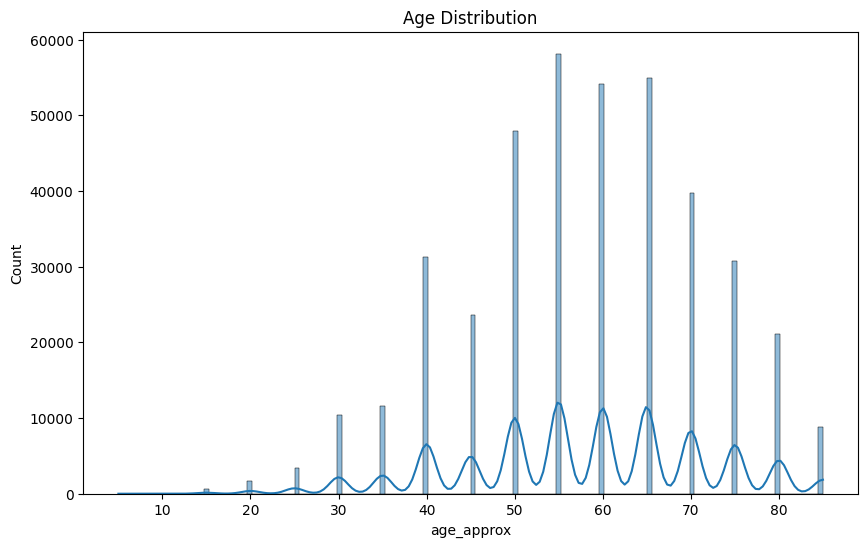

In [13]:
# Visualize the distribution of patient ages
plt.figure(figsize=(10, 6))
sns.histplot(train_metadata['age_approx'], kde=True)
plt.title('Age Distribution')
plt.show()


### **Age Distribution Analysis:**
**Observation:** The age distribution is multimodal, with noticeable peaks at specific ages, particularly in the 50-70 age range. This indicates that the dataset predominantly consists of older adults, which aligns with the higher risk of skin cancer in this age group.

**Next Steps:** Given the concentration of cases in older age groups, age should be considered a significant feature in model training. May also want to investigate any correlations between age and lesion malignancy.

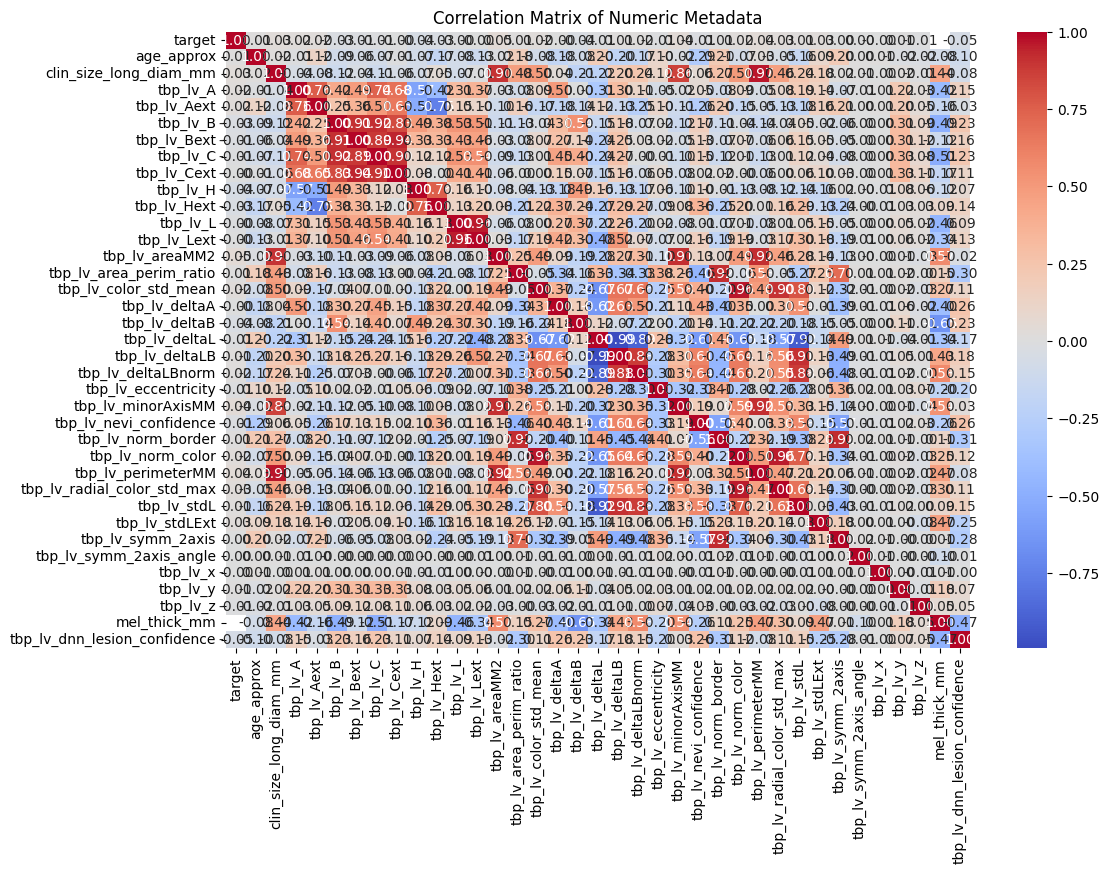

In [14]:
# Examine correlations between numerical metadata features
# Drop non-numeric columns that are not useful for correlation
train_metadata_numeric = train_metadata.drop(columns=['isic_id', 'patient_id'])  # Drop any non-numeric identifiers

# Select only numeric columns again if needed
numeric_columns = train_metadata_numeric.select_dtypes(include=[np.number])

# Calculate and visualize the correlation matrix
corr_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Metadata')
plt.show()




### **Correlation Matrix Analysis:**
**Target Correlation:** The target variable (benign vs. malignant) shows weak correlations with other features, indicating that no single feature strongly predicts malignancy on its own.

The correlation between age_approx and target (lesion malignancy) is approximately 0.01, as indicated in the correlation matrix. This very low correlation suggests that age alone is not a strong predictor of whether a lesion is malignant or benign in this dataset. However, age might still play an indirect role when combined with other features.

**Feature Interrelationships:** Some features like tbp_lv_A, tbp_lv_B, tbp_lv_C, and their extended variants show moderate to strong correlations with each other, suggesting they capture similar aspects of the lesions (e.g., color or texture).

**Multicollinearity Risk:** The presence of strong correlations between certain features (e.g., between different tbp_lv_ features) indicates potential multicollinearity, which may require dimensionality reduction techniques like PCA or careful feature selection

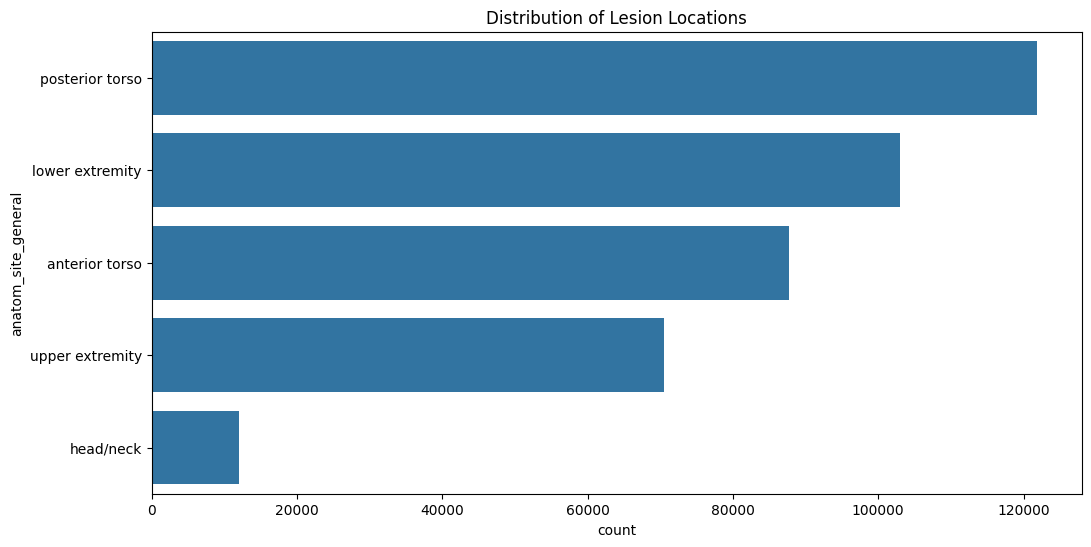

In [15]:
# Visualize the distribution of lesion locations on the body
plt.figure(figsize=(12, 6))
sns.countplot(y='anatom_site_general', data=train_metadata, order=train_metadata['anatom_site_general'].value_counts().index)
plt.title('Distribution of Lesion Locations')
plt.show()


### **Distribution of Lesion Locations:**
**Observation:** The majority of lesions are located on the posterior torso, followed by the lower extremity, anterior torso, and upper extremity. The head/neck region has the fewest lesions.

**Implications:** The high prevalence of lesions on the torso regions (both anterior and posterior) suggests these areas might be more prone to skin conditions being studied. The model should account for location as a potentially significant feature, as different body parts might have varying risks of malignancy.

**Skewed Distribution:** Given that the distribution is not uniform and is skewed towards certain locations (especially the posterior torso), it would be reasonable to fill the missing values with the most common location, which is the posterior torso.

#5. Data Preprocessing

Handling Missing Values:

Imputation: Fill missing values in numerical columns with the median.
Mode for categorical columns.

In [16]:
train_metadata['age_approx'].fillna(train_metadata['age_approx'].median(), inplace=True)
train_metadata['sex'].fillna(train_metadata['sex'].mode()[0], inplace=True)


In [17]:
# Fill missing values with the most frequent location (mode)
train_metadata['anatom_site_general'].fillna(train_metadata['anatom_site_general'].mode()[0], inplace=True)

Encoding Categorical Variables:

One-Hot Encoding: Convert categorical variables like sex and anatom_site_general into one-hot encoded vectors.

In [18]:
train_metadata = pd.get_dummies(train_metadata, columns=['sex', 'anatom_site_general'], drop_first=True)


### **Normalizing Continuous Variables:**
**Improves Model Convergence:** Normalizing continuous features helps gradient-based models like neural networks converge more quickly during training.

R**educes Bias Toward Larger Values:** Features with larger scales can dominate the learning process, leading to models that might underutilize features with smaller scales.

**Standardization:** Normalize continuous variables like age_approx to ensure consistent input scales for the model.

In [19]:
from sklearn.preprocessing import StandardScaler

# Identify continuous columns to normalize
continuous_columns = [
    'age_approx', 'clin_size_long_diam_mm', 'mel_thick_mm',
    'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
    'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
    'tbp_lv_perimeterMM', 'tbp_lv_color_std_mean',
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL',
    'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity',
    'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
    'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'tbp_lv_dnn_lesion_confidence'
]

# Normalize the continuous columns
scaler = StandardScaler()
train_metadata[continuous_columns] = scaler.fit_transform(train_metadata[continuous_columns])


# **Final Important Observations Before Feature Engineering:**
## **Class Imbalance:**

The dataset is heavily skewed towards benign cases, which may cause models to bias towards predicting benign outcomes. Addressing this imbalance will be crucial in feature engineering and model development.

## **Lesion Location Skewness:**

The distribution of lesion locations is skewed, with a majority of lesions found on the posterior torso.  Missing values for lesion location with the mode (posterior torso) are filled, but this skewness should be kept in mind during feature engineering to avoid bias.

## **Weak Correlations with Malignancy:**

Individual features generally show weak correlations with the target variable (malignancy). This suggests that single features may not be strong predictors, and the model will likely benefit from interactions and combinations of multiple features.

##**Missing Values Handled:**

Missing values in critical columns like age_approx, sex, and anatom_site_general have been filled appropriately, ensuring that the dataset is complete and ready for modeling.

##**Feature Scaling:**

Continuous features, including age_approx, lesion sizes, and various lesion characteristics, have been normalized. This ensures that all features are on a comparable scale, which is particularly important for models sensitive to feature magnitude, such as neural networks.

# **Considerations for Feature Engineering:**

1.   Addressing Class Imbalance: To balance the dataset and prevent models from being biased towards the majority class.
2.   Explore creating interaction features (e.g., combinations of age, lesion size, and location) to capture more complex patterns in the data.
3.   Dimensionality Reduction: to reduce multicollinearity and noise while retaining important information.
4.  Feature Selection: With many features available, it is important to identify which ones are most predictive of malignancy.
5. Feature Transformation: Consider transforming certain features if their distributions are highly skewed. This can make patterns in the data more linear and easier for models to learn.



# **6. Feature Engineering**

##### As per the pre-processing data, we can see some columns do not contribute much to the analysis. Those columns are very specific to some cases, hence we drop such columns.

In [20]:
train_metadata.dtypes

,0
isic_id,object
target,int64
patient_id,object
age_approx,float64
clin_size_long_diam_mm,float64
image_type,object
tbp_tile_type,object
tbp_lv_A,float64
tbp_lv_Aext,float64
tbp_lv_B,float64


In [21]:
#The below columns do not add much significance in predicting hence these columns are dropped
columns_to_drop = ['image_type', 'tbp_lv_location_simple','copyright_license','lesion_id','iddx_full','iddx_1',
                    'iddx_2','iddx_3','iddx_4','iddx_5',
                    'mel_mitotic_index','mel_thick_mm','patient_id']
train_metadata = train_metadata.drop(columns=columns_to_drop)

## **Creating new features:**

The individual features in this dataset, like tbp_lv_areaMM2, tbp_lv_perimeterMM have high correlation to each other but not towards our target variable when checked independently. Hence some of these features are combined together to create a new feature.

These new features will be integrated to our existing training dataframe and will be further analysed by performing correlation.



In [22]:
# 1. Interactions Involving Lesion Size and Shape
train_metadata['aspect_ratio_interaction'] = train_metadata['clin_size_long_diam_mm'] / train_metadata['tbp_lv_minorAxisMM']
train_metadata['size_perimeter_interaction'] = train_metadata['clin_size_long_diam_mm'] * train_metadata['tbp_lv_perimeterMM']
train_metadata['area_perimeter_interaction'] = train_metadata['tbp_lv_areaMM2'] * train_metadata['tbp_lv_perimeterMM']

# 2. Color and Texture Interactions
train_metadata['color_variability_deltaA_interaction'] = train_metadata['tbp_lv_color_std_mean'] * train_metadata['tbp_lv_deltaA']
train_metadata['color_variability_deltaB_interaction'] = train_metadata['tbp_lv_color_std_mean'] * train_metadata['tbp_lv_deltaB']
train_metadata['color_variability_deltaL_interaction'] = train_metadata['tbp_lv_color_std_mean'] * train_metadata['tbp_lv_deltaL']
train_metadata['color_asymmetry_symmetry_interaction'] = train_metadata['tbp_lv_radial_color_std_max'] * train_metadata['tbp_lv_symm_2axis']

# 3. Geometric and Positional Interactions
train_metadata['symmetry_eccentricity_interaction'] = train_metadata['tbp_lv_symm_2axis'] * train_metadata['tbp_lv_eccentricity']
train_metadata['size_x_coord_interaction'] = train_metadata['clin_size_long_diam_mm'] * train_metadata['tbp_lv_x']

# 4. Clinical Estimations and Standard Measurements Interactions
train_metadata['nevi_confidence_border_irregularity_interaction'] = train_metadata['tbp_lv_nevi_confidence'] * train_metadata['tbp_lv_norm_border']
train_metadata['color_border_irregularity_interaction'] = train_metadata['tbp_lv_norm_color'] * train_metadata['tbp_lv_norm_border']

# 5. Advanced Interactions Involving Age
train_metadata['age_nevi_confidence_interaction'] = train_metadata['age_approx'] * train_metadata['tbp_lv_nevi_confidence']
train_metadata['age_symmetry_interaction'] = train_metadata['age_approx'] * train_metadata['tbp_lv_symm_2axis']



In [23]:
train_metadata.columns

Index(['isic_id', 'target', 'age_approx', 'clin_size_long_diam_mm',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution',
       'tbp_lv_dnn_lesion_confidence', 'sex_male',
       'anatom_site_general_head/neck', 'anatom_site_general_lower extremity',
       'anatom_site_general_posterior torso',
       'anatom_site_general_upper extremity', 'aspect_r

In [24]:
train_metadata_copy = train_metadata.copy()

In [25]:
# List of newly created interaction features
interaction_features = [
    'aspect_ratio_interaction',
    'size_perimeter_interaction',
    'area_perimeter_interaction',
    'color_variability_deltaA_interaction',
    'color_variability_deltaB_interaction',
    'color_variability_deltaL_interaction',
    'color_asymmetry_symmetry_interaction',
    'symmetry_eccentricity_interaction',
    'size_x_coord_interaction',
    'nevi_confidence_border_irregularity_interaction',
    'color_border_irregularity_interaction',
    'age_nevi_confidence_interaction',
    'age_symmetry_interaction'
]



##### Performing the correlation between the newly created features and old features with our target feature.

In [26]:
# Drop any non-numeric identifiers
train_metadata_features = train_metadata.drop(columns=['isic_id'])

# Select only numeric columns again if needed
numeric_columns = train_metadata_features.select_dtypes(include=[np.number])

# Calculate and visualize the correlation matrix
corr_matrix = numeric_columns.corr()
target_correlations = corr_matrix['target'].sort_values(ascending=False)

# Print the correlation values
print(target_correlations)


target                                             1.000000
tbp_lv_areaMM2                                     0.045139
size_perimeter_interaction                         0.043249
area_perimeter_interaction                         0.041092
tbp_lv_perimeterMM                                 0.036188
tbp_lv_minorAxisMM                                 0.035757
clin_size_long_diam_mm                             0.032682
tbp_lv_stdLExt                                     0.026084
tbp_lv_radial_color_std_max                        0.025441
tbp_lv_color_std_mean                              0.024271
tbp_lv_Aext                                        0.023206
tbp_lv_norm_color                                  0.022264
tbp_lv_A                                           0.019788
tbp_lv_deltaLBnorm                                 0.015172
tbp_lv_stdL                                        0.012669
tbp_lv_deltaLB                                     0.012237
color_border_irregularity_interaction   

## Principal Component Analysis


##### Since the dataset has numerous amount of features, we can perform dimensionality reduction to understand the most important features which retains maximum information.

##### We have 3 different categories of data: boolean, categorical (object type) and numeric. Since PCA expects only the numeric kind of data, we adjust the data accordingly to perform PCA.

As of now the principal components are kept at 25. This can be tuned depending on the model performance as well.

In [27]:
#Performing encoding of the location column of the lesion (tbp_lv_location)
location_encoding = pd.get_dummies(train_metadata, columns=['tbp_lv_location'])

In [28]:
train_metadata = location_encoding
train_metadata.columns

Index(['isic_id', 'target', 'age_approx', 'clin_size_long_diam_mm',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
       'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'tbp_lv_dnn_lesion_confidence', 'sex_male',
       'anatom_site_general_head/neck', 'anatom_site_general_lower extremity',
       'anatom_site_general_posterior torso',
       'anatom_site_general_upper extremity', 'aspect_ratio_interaction',
       

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate `isic_id` as it is a unique id for each row
isic_id = train_metadata['isic_id']
target = train_metadata['target']
train_metadata = train_metadata.drop(['target'], axis=1)  # Remove target before PCA

# # Define preprocessing for categorical features (object types)
# categorical_features = train_metadata.select_dtypes(include=['object']).columns.tolist()
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(drop='first'))
# ])

# Preprocessing for numeric features
numeric_features = train_metadata.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for boolean features
boolean_features = train_metadata.select_dtypes(include=['bool']).columns.tolist()
boolean_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bool', boolean_transformer, boolean_features)
    ])

# Creating the pipeline with preprocessing and PCA
pca_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('pca', PCA(n_components=25))])  # Adjust `n_components` as needed

# Apply the pipeline to the data
pca_result = pca_pipeline.fit_transform(train_metadata)

# Re-attach `isic_id` to the PCA results
train_metadata_pca = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
train_metadata_pca['isic_id'] = isic_id.values

# The `train_metadata_pca` DataFrame now contains the PCA results along with the `isic_id` for each observation
print(train_metadata_pca.head())

# Optionally, if you want to add the target back for further processing or model building:
train_metadata_pca['target'] = target.values


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.383950  0.241291  0.643771 -2.761315  3.508021 -3.526118  2.175911   
1 -3.956551 -1.333058  2.898002 -6.399629 -1.988577  4.744203 -0.136277   
2 -1.709821 -3.982141  3.223719  0.888635  0.643251 -2.062989 -1.473238   
3 -2.720016  2.073354 -2.556274  1.047771 -3.025140  0.750550 -0.491588   
4 -2.795841 -1.195167  1.198480 -2.449840 -0.302376  0.968172  0.214084   

        PC8       PC9      PC10  ...      PC17      PC18      PC19      PC20  \
0  0.922773  0.212146  0.003770  ... -0.722948 -0.885904  0.790539  1.940271   
1  4.231123  2.227743  0.257703  ... -0.258350  0.693157  1.345258 -1.644623   
2  0.172830  0.135215  0.495851  ...  0.557977 -0.530212  0.199126 -0.367838   
3  0.916747 -0.692898 -0.595525  ... -0.732467 -0.731396  0.037936 -0.069372   
4  0.777627 -1.408308 -0.506731  ... -1.750425  0.008629  0.002434 -1.035614   

       PC21      PC22      PC23      PC24      PC25       isic_id  


In [30]:
# Explained Variance Ratio by each Principal Component (PC)
explained_variance = pca_pipeline.named_steps['pca'].explained_variance_ratio_
print("Explained Variance by each PC:\n")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")

# Feature Names after Preprocessing
feature_names = numeric_features + boolean_features

# PCA Components (Loadings)
components = pca_pipeline.named_steps['pca'].components_

#DataFrame to show the loadings
loadings_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=feature_names)


#To see the loadings and explained variance together:
print("\nExplained Variance and Top Contributing Features per PC:\n")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} variance explained")
    print("Top contributing features:")
    top_features = loadings_df.iloc[:, i].abs().sort_values(ascending=False).head(5)
    print(top_features)
    print()


Explained Variance by each PC:

PC1: 0.1238
PC2: 0.0898
PC3: 0.0682
PC4: 0.0458
PC5: 0.0389
PC6: 0.0371
PC7: 0.0353
PC8: 0.0287
PC9: 0.0262
PC10: 0.0252
PC11: 0.0223
PC12: 0.0221
PC13: 0.0197
PC14: 0.0181
PC15: 0.0163
PC16: 0.0158
PC17: 0.0153
PC18: 0.0149
PC19: 0.0144
PC20: 0.0143
PC21: 0.0141
PC22: 0.0140
PC23: 0.0139
PC24: 0.0137
PC25: 0.0136

Explained Variance and Top Contributing Features per PC:

PC1: 0.1238 variance explained
Top contributing features:
tbp_lv_deltaLB           0.295539
tbp_lv_deltaL            0.295529
tbp_lv_stdL              0.291987
tbp_lv_color_std_mean    0.277510
tbp_lv_norm_color        0.271696
Name: PC1, dtype: float64

PC2: 0.0898 variance explained
Top contributing features:
tbp_lv_C              0.296983
tbp_lv_B              0.293785
tbp_lv_perimeterMM    0.258621
tbp_lv_Bext           0.257267
tbp_lv_Cext           0.246557
Name: PC2, dtype: float64

PC3: 0.0682 variance explained
Top contributing features:
tbp_lv_area_perim_ratio    0.276394
tbp_

#### Creating dataset for model development using the selected features from the PCA and correlation analysis.

In [31]:
train_metadata_pca.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'isic_id', 'target'],
      dtype='object')

In [32]:
selected_features = [
    'isic_id',
    'PC2',
    'PC3',
    'PC1',
    'PC4',
    'PC5',
    'target'
]

# Attach `isic_id` to the train_metadata set as it was earlier dropped
# train_metadata['isic_id'] = isic_id.values
train_metadata_selected_features = train_metadata_pca[selected_features]
# train_metadata_selected_features['target'] = train_metadata['target']
print(train_metadata_selected_features.head())

        isic_id       PC2       PC3       PC1       PC4       PC5  target
0  ISIC_0015670  0.241291  0.643771 -3.383950 -2.761315  3.508021       0
1  ISIC_0015845 -1.333058  2.898002 -3.956551 -6.399629 -1.988577       0
2  ISIC_0015864 -3.982141  3.223719 -1.709821  0.888635  0.643251       0
3  ISIC_0015902  2.073354 -2.556274 -2.720016  1.047771 -3.025140       0
4  ISIC_0024200 -1.195167  1.198480 -2.795841 -2.449840 -0.302376       0


In [33]:
#Final dataset which has to be used for the model development
train_metadata_selected_features.columns

Index(['isic_id', 'PC2', 'PC3', 'PC1', 'PC4', 'PC5', 'target'], dtype='object')

# Resampling Techniques to Help Class Imbalance

### Oversampling the Minority Class (Malignant Cases):
SMOTE (Synthetic Minority Over-sampling Technique): This technique generates synthetic samples in the feature space for the minority class to balance the dataset.

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target
X = train_metadata_selected_features.drop(columns=['target'])
y = train_metadata_selected_features['target']

# Check if 'isic_id' exists in the DataFrame
if 'isic_id' in X.columns:
    isic_id = X['isic_id']
    X = X.drop(columns=['isic_id'])  # Drop 'isic_id' if it exists
else:
    isic_id = None

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Optionally, track synthetic samples or reattach 'isic_id'
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)

# Handle 'isic_id' for synthetic samples (if applicable)
if isic_id is not None:
    # Generate synthetic 'isic_id'
    new_isic_ids = ['synthetic_' + str(i) for i in range(len(X_train_smote) - len(X_train))]
    original_isic_ids = isic_id.iloc[X_train.index].tolist()  # Get 'isic_id' for original training samples
    X_train_smote['isic_id'] = original_isic_ids + new_isic_ids
else:
    print("'isic_id' was not found in the original data.")

# For validation set, reattach original 'isic_id' if it exists
if isic_id is not None:
    X_val['isic_id'] = isic_id.iloc[X_val.index].values


In [35]:
X_train_smote.head()

,PC2,PC3,PC1,PC4,PC5,isic_id
0,-3.990487,-0.267856,7.773076,0.285751,1.429377,ISIC_3283637
1,-1.347874,-0.752599,1.825867,4.198819,-0.332070,ISIC_5518492
2,-3.693153,0.525520,1.781697,2.098493,1.309866,ISIC_1821584
3,16.538419,12.688333,15.142324,7.190884,1.759367,ISIC_8102613
4,0.968426,-1.101162,-2.453924,0.212385,-1.795953,ISIC_6194285


 After applying SMOTE, we have to ensure to validate the model using cross-validation or on a separate validation set to check if the model’s performance on the minority class has improved without causing overfitting.

## Implementing LightGBM to handle the class imbalance and perform cross-validation.

LightBGM has built-in support for handling imbalanced data via parameters like 'scale_pos_weight'.

In [36]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix


num_negatives = sum(y_train_smote == 0)
num_positives = sum(y_train_smote == 1)
scale_pos_weight = num_negatives / num_positives
print(f'Scale Pos Weight: {scale_pos_weight}')


X_train_smote = X_train_smote.drop(columns=['isic_id'])
X_val = X_val.drop(columns=['isic_id'])


scale_pos_weight = num_negatives / num_positives

# Initialize and train the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
lgb_model.fit(X_train_smote, y_train_smote)

# Predict on the validation set with LightGBM
y_val_pred_lgb = lgb_model.predict(X_val)

# Print the confusion matrix and classification report for LightGBM
print("\nConfusion Matrix on Validation Set (LightGBM):")
print(confusion_matrix(y_val, y_val_pred_lgb))
print("\nClassification Report on Validation Set (LightGBM):")
print(classification_report(y_val, y_val_pred_lgb))


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Scale Pos Weight: 1.0
[LightGBM] [Info] Number of positive: 320533, number of negative: 320533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 641066, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Confusion Matrix on Validation Set (LightGBM):
[[74148  5985]
 [   29    50]]

Classification Report on Validation Set (LightGBM):
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     80133
           1       0.01      0.63      0.02        79

    accuracy                           0.93     80212
   macro avg       0.50      0.78      0.49     80212
weighted avg       1.00      0.93      0.96     80212



### **Analysis of the confusion matrix**

*   **Class 0 (Majority Class)**: The model correctly identified 93% of the actual class 0 cases as seen by the recall score
*   **Class 1 (Minority Class)**: The model identified 63% of the actual class 1 cases. The F1-score is very low, indicating poor balance between precision and recall for class 1.


*   **Weighted Avg**: These metrics are heavily skewed by the majority class, leading to a high overall score but masking the performance on the minority class.
*   The recall for class 1 (minority class) is 0.63, which is a good result given the class imbalance. However, the precision remains very low at 0.01, indicating that many instances are incorrectly classified as positive.

The model is performing well on the majority class but is still struggling with precision for the minority class.














In [37]:
# Performing cross-validation on training set

from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define the cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# X_train_smote = X_train_smote.drop(columns=['isic_id'])

# Perform cross-validation
cv_scores = cross_val_score(lgb_model, X_train_smote, y_train_smote, cv=skf, scoring='f1_macro', n_jobs=-1)

# Evaluate and print results
print(f'Cross-Validation F1 Macro Scores: {cv_scores}')
print(f'Mean CV F1 Macro Score: {cv_scores.mean()}')
print(f'Standard Deviation of CV Scores: {cv_scores.std()}')


Cross-Validation F1 Macro Scores: [0.94908725 0.94734541 0.94722252 0.94858519 0.94923554]
Mean CV F1 Macro Score: 0.9482951797009186
Standard Deviation of CV Scores: 0.0008542142558440264
